# Exam - Sophia Wilson

I use my own library 'AdvAppStatFunctions' which contains many functions that I made in the course Applied Statistics and that I have extended i in this course. I will write at the particular problem if I use any code not made by myself.

In [1]:
# Standard libraires
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats, interpolate
from scipy.optimize import minimize
import itertools
from iminuit import Minuit   
import copy
from tqdm.notebook import tqdm

# Nested fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# External library
import sys  
from importlib import reload
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 18
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc

In [2]:
#import warnings
#warnings.filterwarnings('ignore')


SaveFig = False

# Problem 5A

### Parsing data

In [3]:
data = np.loadtxt('Data/Exam_2023_Problem5a.txt')
N_bins = 55

### Visualizing data

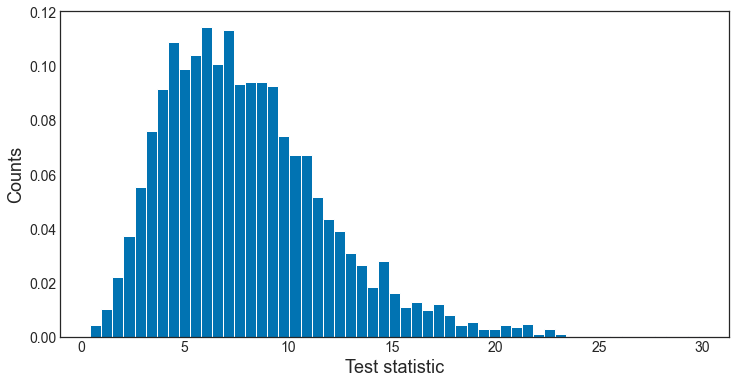

In [4]:
# Plot data
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(data, bins=N_bins, density=True, zorder=2)

ax.set(ylabel='Counts', xlabel='Test statistic')
plt.show()

## Question 1

The file is a list of 3000 bootstrap test-statistic samples. What is
the critical value, i.e. threshold, of the test-statistic that
corresponds to a one-sided p-value of 4.55%?

Code by Kimi Kreilgaard from https://github.com/KimiKreil/Advanced-Methods-in-Applied-Statistics. 

In [5]:
p_value = 0.0455

# array with critical values  
crit_arr = np.linspace(0,30,1001)

# array to store p values
p_arr = np.zeros(len(crit_arr))

# loop over data
for i in range(len(crit_arr)):
    p_arr[i] = aas.compute_p_val(crit_arr[i], data)

In [6]:
# extract the critical value that is closest to p_want
idx = np.argmin(abs(p_arr - p_value))
crit_arr[idx], p_arr[idx], idx

(15.69, 0.04533333333333334, 523)

In [7]:
print(p_arr[idx-1], p_arr[idx-1] - p_value)
print(p_arr[idx], p_arr[idx] - p_value)
print(crit_arr[idx-1], crit_arr[idx])

0.04566666666666667 0.00016666666666666913
0.04533333333333334 -0.0001666666666666622
15.66 15.69


In [8]:
p_found = (p_arr[idx-1]+p_arr[idx])/2
crit_found = (crit_arr[idx-1]+crit_arr[idx])/2
print('p found: %s, \ncritical value found: %s' %(p_found, crit_found))

p found: 0.0455, 
critical value found: 15.675


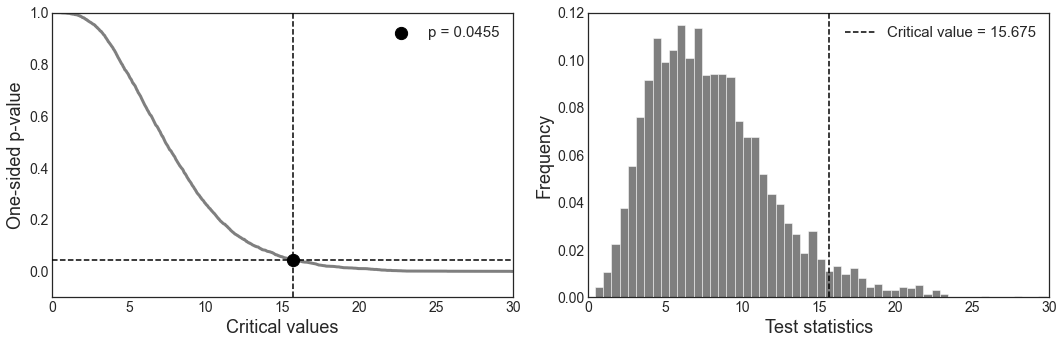

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# Finding it ------------

ax[0].plot(crit_arr, p_arr, color='k', alpha=0.5, linewidth=3)

ax[0].hlines(p_found, 0, 30, color='k', linestyle='dashed', zorder=4)
ax[0].vlines(crit_found, -0.1, 1, color='k', linestyle='dashed', zorder=4)
ax[0].scatter(crit_found, p_found, color='k', s=150, zorder=5, label=f'p = {p_found:.4f}')

ax[0].set_xlabel('Critical values')
ax[0].set_ylabel('One-sided p-value')
ax[0].legend(prop={'size':15})

ax[0].set_xlim(0,30)
ax[0].set_ylim(-0.1,1)

# Displaying on histogramm ----------

ax[1].hist(data, density=True, color='k', alpha=0.5, bins=N_bins, zorder=3)
ax[1].vlines(crit_arr[idx], 0, 0.12, color='k', linestyle='dashed', zorder=4, label=f'Critical value = {crit_found:.3f}')
ax[1].set_xlim(0,30)
ax[1].set_ylim(0,0.12)

ax[1].set_xlabel('Test statistics')
ax[1].set_ylabel('Frequency')
ax[1].legend(prop={'size':15})

plt.tight_layout()
if SaveFig:
    plt.savefig('Figs/5_1.pdf')
plt.show()


## Question 2
If the true distribution for the test-statistics in the file is chisquared distributed, does the test-statistic threshold established
with the bootstrap samples match the expected critical value
from a chi-squared distribution with 5 degrees-of-freedom (k=5)?

Code by Kimi Kreilgaard from https://github.com/KimiKreil/Advanced-Methods-in-Applied-Statistics. 

In [10]:
# xrange
x_arr = np.linspace(0,30,1000)

# chi2 distributions (pdf)
y_arr5 = stats.chi2.pdf(x_arr,df=5)
y_arr8 = stats.chi2.pdf(x_arr,df=8)

# array for critical values to try
crit_arr_chi = np.linspace(0,50,1000)

# arrays for p values
p_arr5 = np.zeros(1000)
p_arr8 = np.zeros(1000)

# Find the p-value from integration
def compute_p_int(crit_val, y_data, step_size):
    return np.trapz(y_data[x_arr>crit_val], dx=step_size )

for i in range(len(crit_arr_chi)):
    p_arr5[i] = compute_p_int(crit_arr_chi[i], y_arr5, x_arr[1]-x_arr[0])
    p_arr8[i] = compute_p_int(crit_arr_chi[i], y_arr8, x_arr[1]-x_arr[0])
    
# Find the best matches
idx5 = np.argmin(abs(p_arr5 - p_value))
idx8 = np.argmin(abs(p_arr8 - p_value))
crit5, p5 = crit_arr_chi[idx5], p_arr5[idx5]
crit8, p8 = crit_arr_chi[idx8], p_arr8[idx8]

print(f'5dof: crit = {crit5:.2f} \t\t p = {p5:.4f}')
print(f'8dof: crit = {crit8:.2f} \t\t p = {p8:.4f}')

5dof: crit = 11.31 		 p = 0.0454
8dof: crit = 15.77 		 p = 0.0452


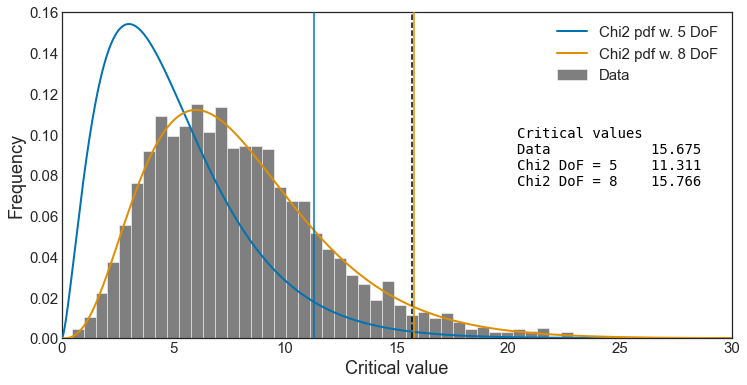

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(data, bins=N_bins, alpha=0.5, color='k', density=True,zorder=2, label='Data')
ax.plot(x_arr, y_arr5, linewidth=2, color=color[0], label= r'Chi2 pdf w. 5 DoF', zorder=3)
ax.plot(x_arr, y_arr8, linewidth=2, color=color[1], ls='solid', label='Chi2 pdf w. 8 DoF', zorder=3)

ax.vlines(crit5, 0, 0.16, color=color[0], linestyle='solid', zorder=4 )# , label=f'Critical value = {crit5:.2f}')
ax.vlines(crit8, 0, 0.16, color=color[1], zorder=4) #, label=f'Critical value = {crit8:.2f}')
ax.vlines(crit_arr[idx], 0, 0.16, color='k', linestyle='dashed', zorder=4) #, label=f'Critical value = {crit_arr[idx]:.2f}')

ax.set_xlabel('Critical value', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)

plt.xlim(0,30)
plt.ylim(0,0.16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.legend(prop={'size':15})



d = {r'Critical values' : '',
     r'Data   ':   crit_found,
     r'Chi2 DoF = 5':      crit5,
     r'Chi2 DoF = 8':      crit8,
     }

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.68, 0.65, text, ax, fontsize=14, color='k')


if SaveFig:
    plt.savefig('Figs/5_2.pdf')
plt.show()

### Chi 2 values

In [12]:
def pdf_5(x):
    return stats.chi2.pdf(x,df=5)

def pdf_7(x):
    return stats.chi2.pdf(x,df=7)

def pdf_8(x):
    return stats.chi2.pdf(x,df=8)

def pdf_9(x):
    return stats.chi2.pdf(x,df=9)

chi2_red_5, prob_5, _ =  aas.chi2_hist(data, pdf_5, [], N_bins)
chi2_red_7, prob_7, _ =  aas.chi2_hist(data, pdf_7, [], N_bins)
chi2_red_8, prob_8, _ =  aas.chi2_hist(data, pdf_8, [], N_bins)
chi2_red_9, prob_9, _ =  aas.chi2_hist(data, pdf_9, [], N_bins)

The reduced Chi2 is: 65.7850 with a p-value of: 0.0000
The reduced Chi2 is: 6.3054 with a p-value of: 0.0000
The reduced Chi2 is: 0.9770 with a p-value of: 0.5165
The reduced Chi2 is: 5.6336 with a p-value of: 0.0000


# MC

In [13]:
xmin, xmax, N_points = min(data), max(data), len(data)

p5_array = []
crit5_array = []

for _ in range(10000):
    X_accepted, Y_accepted, eff = aas.acceptandreject(pdf_5, xmin, xmax, N_points)
    
    p5 = []
    for i in range(len(crit_arr)):
        p5.append(aas.compute_p_val(crit_arr[i], X_accepted))
        
    p5 = np.array(p5)
    # extract the critical value that is closest to p_want
    idx5 = np.argmin(abs(p5 - p_value))
    p5_array.append(p5[idx5])
    crit5_array.append(crit_arr[idx5])

In [14]:
p8_array = []
crit8_array = []

for _ in range(10000):
    X_accepted, Y_accepted, eff = aas.acceptandreject(pdf_8, xmin, xmax, N_points)
    
    p8 = []
    for i in range(len(crit_arr)):
        p8.append(aas.compute_p_val(crit_arr[i], X_accepted))
        
    p8 = np.array(p8)
    # extract the critical value that is closest to p_want
    idx8 = np.argmin(abs(p8 - p_value))
    p8_array.append(p8[idx8])
    crit8_array.append(crit_arr[idx8])

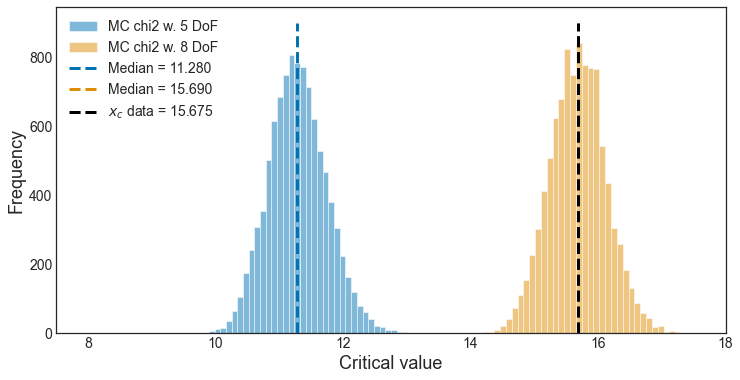

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(crit5_array, bins=39, alpha=0.5, zorder=2, label=r'MC chi2 w. 5 DoF')
ax.vlines(np.median(crit5_array), 0, 900, color=color[0], lw=3, linestyle='dashed', zorder=4, label=f'Median = {np.median(crit5_array):.3f}')
ax.hist(crit8_array, bins=39, color=color[1], alpha=0.5, zorder=2, label=r'MC chi2 w. 8 DoF')
ax.vlines(np.median(crit8_array), 0, 900, color=color[1], lw=3, linestyle='dashed', zorder=4, label=f'Median = {np.median(crit8_array):.3f}')
ax.vlines(crit_arr[idx], 0, 900, color='k', lw=3, linestyle='dashed', zorder=4, label=r'$x_c$ data = %s' %crit_found)


ax.legend(loc='upper left')
ax.set(xlim=(7.5, 18), xlabel='Critical value', ylabel='Frequency')
fig.savefig('Figs/5_3.pdf')


# 5b

Make a linear and a Piecewise Cubic Hermite Interpolating
Polynomial (PCHIP) spline using the following (x, y) data:
(1, 3.4), (1.7, 3.9), (1.9, 2.6), and (2.2, 3.1)

What is the interpolated y-value for x=2.0 from the linear
spline and the PCHIP spline?

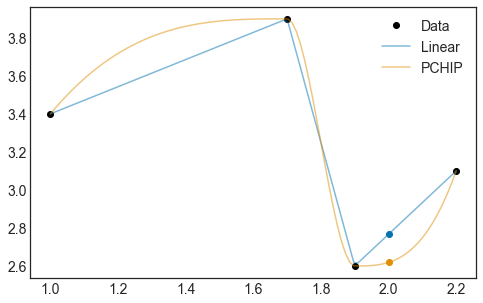

In [16]:
from scipy.interpolate import interp1d, PchipInterpolator
import matplotlib.pyplot as plt

# Given data
x = np.array([1, 1.7, 1.9, 2.2])
y = np.array([3.4, 3.9, 2.6, 3.1])
x0 = 2.0

# Linear interpolation
f_linear = interp1d(x, y, kind='linear')
y_linear = f_linear(x0)

# PCHIP interpolation
f_pchip = PchipInterpolator(x, y)
y_pchip = f_pchip(x0)

# Plotting the data and interpolations
x_new = np.linspace(1, 2.2, 100)

fig = plt.figure(figsize=(8,5))
plt.plot(x, y, 'o', color='k', label='Data')
plt.plot(x_new, f_linear(x_new), label='Linear', alpha=0.5)
plt.plot(x_new, f_pchip(x_new), '-', label='PCHIP', alpha=0.5)
plt.plot(x0, y_linear, 'o', color=color[0])
plt.plot(x0, y_pchip, 'o', color=color[1])
plt.legend()
plt.show()
fig.savefig('Figs/5_5.pdf')

In [17]:
# Linear interpolation
f_linear = interp1d(x, y, kind='linear')
y_linear = f_linear(2.0)
print("Interpolated y-value for x=2.0 using linear spline: ", y_linear)

# PCHIP interpolation
f_pchip = PchipInterpolator(x, y)
y_pchip = f_pchip(2.0)
print("Interpolated y-value for x=2.0 using PCHIP spline: ", y_pchip)

Interpolated y-value for x=2.0 using linear spline:  2.7666666666666666
Interpolated y-value for x=2.0 using PCHIP spline:  2.6185185185185187
